A notebook for exploring SNMR data and inversions in their current format.

Neil Symington

neil.symington@ga.gov.au

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlalchemy as db
from sqlite3 import dbapi2 as sqlite
from hydrogeol_utils import SNMR_utils
import h5py
from shapely import wkt
from shapely import wkb

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


We will start by looking at the processed data files. These were originally in matlab container files but I transferred them to hdf5. The container structure was a straight conversion using octave and is in my opion rather silly.

In [31]:
filename = r"""\\prod.lan\active\proj\futurex\East_Kimberley\Data\Processed\Geophysics\NMR\SNMR\processed_data_hdf5\OB18_30_FID_60ms.hdf5"""

f = h5py.File(filename, 'r')

# Get the group name
gp = list(f.keys())

print(gp)

# Get the second group name
gp2 = list(f['data'].keys())

print(gp2)

# Get the third group keys, which are the actual data
gp3 = list(f['data']['value'].keys())

print(gp3)


['data']
['type', 'value']
['T_dead_time', 'T_pulse', 'coil_1_fid', 'coil_2_fid', 'coil_3_fid', 'coil_4_fid', 'detect_frequency', 'fs', 'interpulse_delay', 'pulse_moment', 'pulse_moment_phase', 'pulse_moment_voltage', 'pulse_moment_voltage_phase', 'pulse_sequence', 'time_fid']


In [4]:
# An adhoc function to extract the SNMR data from hdf5 container files

def extract_data(f, table_name):
    return (f['data']['value'][table_name]['value'].value)


In [5]:
# Here we extract an array
coil_1_fid = extract_data(f, 'coil_1_fid')

print(np.shape(coil_1_fid))

(28, 3647)


In [6]:
# Here we extract a scalar
print(extract_data(f, 'T_dead_time'))

0.01034


The matlab files are inverted to generate water content profiles using the GMR inversion software. I won't go into this process but it includes a command line interface allowing batch inversion given a csv file input. The inversions also accept a conductivity profile as an input which are derived from the AEM inversion.

I created my own spatialite database for ease of accesssing the data. The process for creating this databse is describe dhere:

https://github.com/Neil-Symington/hydrogeol_utils/blob/Neil_dev/notebooks/create_SNMR_spatialite-db.ipynb


In [9]:
# Lets explore the database

# Connect to the SNMR database

DB_PATH = r"\\prod.lan\active\proj\futurex\East_Kimberley\Data\Processed\Geophysics\NMR\SNMR\East_Kimberley_SNMR.sqlite"
        
engine = db.create_engine('sqlite:///' + DB_PATH, module=sqlite)

connection = engine.connect()

In [10]:
# Let have a look at the tables
print(engine.table_names())

['ElementaryGeometries', 'KNN', 'SpatialIndex', 'acquisitions', 'data_licenses', 'geometry_columns', 'geometry_columns_auth', 'geometry_columns_field_infos', 'geometry_columns_statistics', 'geometry_columns_time', 'inverse_model_metadata', 'inverse_models', 'sites', 'spatial_ref_sys', 'spatial_ref_sys_aux', 'spatialite_history', 'sql_statements_log', 'sqlite_sequence', 'views_geometry_columns', 'views_geometry_columns_auth', 'views_geometry_columns_field_infos', 'views_geometry_columns_statistics', 'virts_geometry_columns', 'virts_geometry_columns_auth', 'virts_geometry_columns_field_infos', 'virts_geometry_columns_statistics']


In [12]:
# The key tables holding the important data are the following

# The sites table contains metadata to each site

df_sites = pd.read_sql('SELECT * from sites;', connection, index_col = 'site_id')

print(df_sites.head(2))

              Field_ID       Site_Code       mid_X        mid_Y  \
site_id                                                           
0             MillProf  EKSNMR16091601  466505.910  8316696.170   
1        saltflats_st1  EKSNMR16091701  468448.666  8354121.638   

         declination_angle  inclination_angle        date  loop_width  \
site_id                                                                 
0                      0.0              -43.7  2016-09-16       100.0   
1                      0.0              -43.7  2016-09-17       100.0   

        coil_type                                           geometry  \
site_id                                                                
0          square  POLYGON ((466296.2798914838 8316647.306548808,...   
1          square  POLYGON ((468500.9411914838 8354169.254548808,...   

                                                      geom  
site_id                                                     
0        b'\x00\x01\xc0n\x0

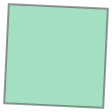

In [13]:
# The geometry column is a wkt polygon, which denotes the geomtry of
# the coil (almost always a square)

wkt_poly = wkt.loads(df_sites.iloc[0].geometry)

wkt_poly

# There is also a wkb column that is used by spatialite

In [14]:
# Now lets look at the acquisition table which contains metadata relating to 
# acquisitions. As there were often more than one acquisition at each site
# the relationship with sites is many to one

df_acquisition = pd.read_sql('SELECT * from acquisitions;', connection,
                             index_col = 'acquisition_id')
df_acquisition.head(10)


,pulse_sequence,pulse_length,site_id
acquisition_id,,,
0,FID,40.0,0
1,CPMG,20.0,0
2,FID,40.0,1
3,FID,40.0,2
4,CPMG,10.0,2
5,FID,40.0,3
6,CPMG,10.0,3
7,FID,40.0,4
8,CPMG,10.0,4


In [101]:
tuple(sid)

(143,)

In [138]:
# The inversion data is kept in a large table that is related to the acquisitons
# Here we join it to acquisitions for site OB18_30

# Find the site_id
mask = df_sites['Field_ID'] == "OB18_30"
sid = df_sites[mask].index


query = "SELECT a.*, i.* FROM acquisitions as a JOIN inverse_models as i on a.acquisition_id=i.acquisition_id WHERE a.site_id = ?;"

df_inversions = pd.read_sql_query(query, connection,
                                 params=tuple(sid))

df_inversions.head(10)


,acquisition_id,pulse_sequence,pulse_length,site_id,table_id,Depth_from,Depth_to,Mobile_water_content,Bound_water_content,Total_water_content,T1,T2,T2*,frequency,phase,site_id,acquisition_id,inversion_id
0,258,FID,60.0,143,12700,0.414881,0.596031,0.001025,0.000000,0.001025,NaN,None,0.341667,2043.3159,0.745765,143,258,254
1,258,FID,60.0,143,12701,0.596031,0.823463,0.002670,0.001929,0.004599,NaN,None,0.251748,2043.1935,3.712982,143,258,254
2,258,FID,60.0,143,12702,0.823463,1.102440,0.002706,0.000000,0.002706,NaN,None,0.309719,2043.2415,3.674753,143,258,254
3,258,FID,60.0,143,12703,1.102440,1.438227,0.003472,0.003102,0.006574,NaN,None,0.293932,2042.9784,0.623540,143,258,254
4,258,FID,60.0,143,12704,1.438227,1.836089,0.000924,0.000000,0.000924,NaN,None,0.262528,2043.4918,4.867124,143,258,254
5,258,FID,60.0,143,12705,1.836089,2.301292,0.000724,0.000000,0.000724,NaN,None,0.184252,2043.5651,4.826270,143,258,254
6,258,FID,60.0,143,12706,2.301292,2.839100,0.001424,0.004348,0.005772,NaN,None,0.443600,2042.9411,4.161983,143,258,254
7,258,FID,60.0,143,12707,2.839100,3.454777,0.004209,0.000263,0.004472,NaN,None,0.192949,2043.3138,3.635841,143,258,254
8,258,FID,60.0,143,12708,3.454777,4.153590,0.001302,0.000000,0.001302,NaN,None,0.068064,2034.7860,1.723726,143,258,254
9,258,FID,60.0,143,12709,4.153590,4.940802,0.008786,0.005078,0.013864,NaN,None,0.294046,2043.1300,1.028823,143,258,254


In [153]:
# We also have an inversion metadata table, here I will pull out the metadata for 
# the inversion above

# Find the site_id

inv_id = df_inversions.inversion_id.unique()

query = "SELECT * FROM inverse_model_metadata i WHERE i.inversion_id in ({});"

placeholder= '?' # For SQLite. See DBAPI paramstyle.
placeholders= ', '.join(placeholder * len(inv_id))

query = query.format(placeholders)

params = tuple(inv_id)

print(params)

# A bug means I cannot pass params but I can pass (254,255)
df_inversion_metadata = pd.read_sql_query(query, connection,
                                          params=(254,255))

print(df_inversion_metadata)

(254, 255)
   inversion_id  Depth_of_Investigation  reg_factor  conductive_earth_model  \
0           254               92.802041        0.02                       1   
1           255               81.518669        0.02                       1   

          Inversion_software  acquisition_id  
0  GMRInversion1D_CLI_v2.7.3             258  
1  GMRInversion1D_CLI_v2.7.3             259  


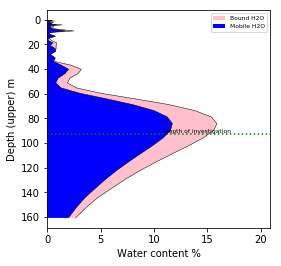

In [162]:
# Finally lets plot an inversion

fig, ax1 = plt.subplots(1,1, sharey=True, figsize = (4,4))

ax1 = SNMR_utils.plot_profile(ax1, df_inversions[df_inversions['inversion_id']==inv_id[0]],
                              doi = df_inversion_metadata[df_inversion_metadata['inversion_id']==
                                                         inv_id[0]]['Depth_of_Investigation'].values)

plt.gca().invert_yaxis()
plt.show()